In [91]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
import numpy as np
from numpy import log,dot,exp,shape
from sklearn.model_selection import train_test_split
import copy
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from operator import add

# 2

In [92]:
train_data = MNIST("./data", train = True, download = True,
                          transform=transforms.ToTensor())

In [93]:
idx = ((train_data.targets==6) | (train_data.targets==9) )
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
X = train_data.data
y = train_data.targets
X =torch.flatten(X, start_dim=1)


In [94]:
#Sub sample size 1000
X  = X[:1000]
y = y[:1000]

In [95]:
X = torch.detach(X).numpy()
y = torch.detach(y).numpy()


In [96]:
## Adding a column for bias
n = X.shape[0]
row = np.array([1]*n).reshape(n, 1)
X = np.append(X, row, axis=1)

In [97]:
y_new =  np.array([1 if p > 7 else 0 for p in y])

In [98]:
X_tr,X_te,y_tr,y_te = train_test_split(X,y_new,test_size=0.1)

In [99]:


def model_plots(accuracies_standard, losses_standard, accuracies_natural, losses_natural):
    plt.figure(figsize=(20,5))
    plt.plot(accuracies_standard)
    plt.plot(accuracies_natural)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(["standard_gradient","natural_gradient"], loc='upper left')
    axes = plt.gca()
    axes.set_ylim([0.3,1])
    plt.show()
    plt.figure(figsize=(20, 5))
    plt.plot(losses_standard)
    plt.plot(losses_natural)
    plt.title('model Loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(["standard_gradient", "natural_gradient"], loc='upper left')
    axes = plt.gca()
    axes.set_ylim([0.1, 12])
    plt.show()
    return

In [100]:



class LogidticRegression:

    def __init__(self, is_natural_gradient):
        self.losses = []
        self.train_accuracies = []
        self.is_natural_gradient = is_natural_gradient

    def _sigmoid(self, x):
        return np.array([self._sigmoid_function(value) for value in x])

    def _sigmoid_function(self, x):
        if x >= 0:
            z = np.exp(-x)
            return 1 / (1 + z)
        else:
            z = np.exp(x)
            return z / (1 + z)

    def initialize(self,X):
        weights = np.zeros((shape(X)[1],1))
        X = np.c_[np.ones((shape(X)[0],1)),X]
        return weights,X


    def predict(self,X):
        z = dot(X,self.weights)
        lis = []
        for i in self._sigmoid(z):
            if i>0.5:
                lis.append(1)
            else:
                lis.append(0)
        return lis


    def compute_loss(self, y_true, y_pred):
        # binary cross entropy
        y_true = y_true.reshape(len(y_true))
        y_zero_loss = y_true * np.log(y_pred + 0.0000000001)
        y_one_loss = (1-y_true) * np.log(1 - y_pred + 0.0000000001)
        return -np.mean(y_zero_loss + y_one_loss)

    def compute_gradients(self, x, y_true, y_pred):
        difference =  y_pred - y_true
        gradient_b = np.mean(difference)
        gradients_w = np.matmul(x.transpose(), difference)
        gradients_w = np.array([np.mean(grad) for grad in gradients_w])
        return gradients_w, gradient_b

    def compute_natural_gradients(self, x, y_true, y_pred):
        difference =  y_pred - y_true
        gradient_b = np.mean(difference)
        gradients_w = np.matmul(x.transpose(), difference)
        d = gradients_w.shape[0]
        n = gradients_w.shape[1]
        grad =torch.from_numpy(gradients_w)
        gradients_w = torch.Tensor([np.mean(grad) for grad in gradients_w]).reshape(d,1)
        gradients_w = gradients_w.double()
        gradients_w_T = torch.transpose(gradients_w,0,1)
        mean_square = torch.matmul(gradients_w, gradients_w_T)
        ep = 10**-9
        for i in range(n):
            br = grad[:,i].reshape(1,d)
            nr = torch.transpose(br,0,1)
            matrix = torch.matmul(nr,br)
            if(i ==0):
                fisher = matrix
            else:
                fisher += matrix
        fisher = fisher/n
        ## The definition for fisher information has been used which has been approved by Proffessor
        fisher = fisher - mean_square
        for i in range(d):
            fisher[i][i] = fisher[i][i] + ep
        fish_inv = torch.inverse(fisher)
        fish_inv =fish_inv.double()

        mapped_gradient = torch.matmul(fish_inv, gradients_w)
        mapped_gradient = torch.detach(mapped_gradient).numpy().reshape(d)
        return mapped_gradient, gradient_b

    def update_model_parameters(self, error_w, learning_rate):
        self.weights = self.weights - learning_rate * error_w


    def fit(self, x, y, weight_init, learning_rate,  epochs = 20):
        x = self._transform_x(x)
        y = self._transform_y(y)

        self.weights = weight_init
        self.bias = 0

        for i in range(epochs):
            x_dot_weights = np.matmul(self.weights, x.transpose()) #+ self.bias
            pred = self._sigmoid(x_dot_weights)
            loss = self.compute_loss(y, pred)
            if(self.is_natural_gradient):
                error_w, _ = self.compute_natural_gradients(x, y, pred)
            else:
                error_w, _ = self.compute_gradients(x, y, pred)

            self.update_model_parameters(error_w, learning_rate)

            pred_to_class = [1 if p > 0.5 else 0 for p in pred]
            self.train_accuracies.append(accuracy_score(y, pred_to_class))
            self.losses.append(loss)
        return

    def _transform_x(self, x):
        x = copy.deepcopy(x)
        return x

    def _transform_y(self, y):
        y = copy.deepcopy(y)
        return y.reshape(y.shape[0], 1)





Epochs stands for number of steps, and iterations stands for the number of random initializations.

_

Iteration number : 1
Training For standard gradient descent
Training For natural gradient descent
Iteration number : 2
Training For standard gradient descent
Training For natural gradient descent
Iteration number : 3
Training For standard gradient descent
Training For natural gradient descent
Iteration number : 4
Training For standard gradient descent
Training For natural gradient descent
Iteration number : 5
Training For standard gradient descent
Training For natural gradient descent


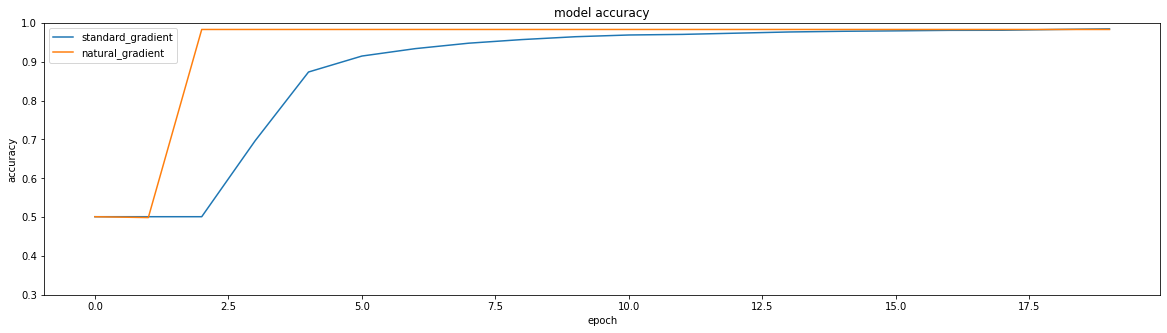

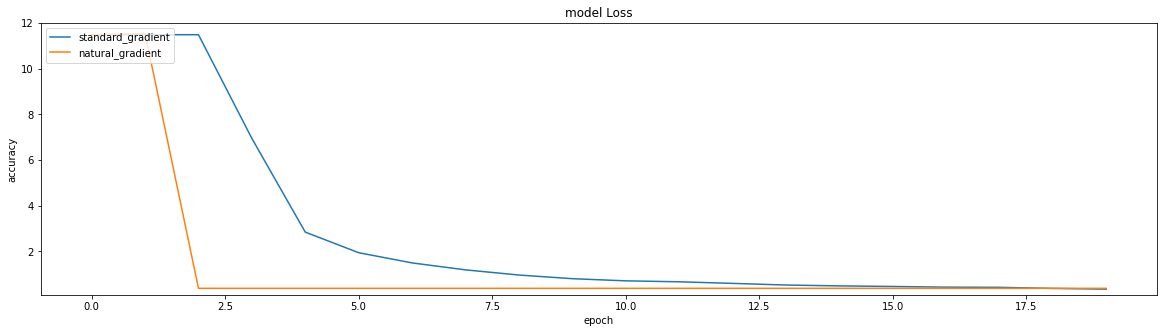

In [101]:
##Plotting with multiple initializations
epochs = 20
accuracies_standard = [0]*epochs
losses_standard = [0]*epochs
accuracies_natural = [0]*epochs
losses_natural = [0]*epochs
iterations = 5
for i in range(iterations):
    print("Iteration number : " + str(i+1))
    weight_init = np.random.rand(X_tr.shape[1])
    ## 0.000003 Is the maximum rate where standard gradient was not sketchy (Prof. Tom Fletcher instructed to  choose the maX
    ## LR which is not sketchy, same Learning rate is chosen for both to make the experiment fair)
    lr = 0.000003
    print("Training For standard gradient descent")
    obj1 = LogidticRegression(is_natural_gradient = False)
    model1= obj1.fit(X_tr,y_tr, weight_init, lr, epochs)
    accuracies_standard = list(map(add,obj1.train_accuracies,  accuracies_standard))
    losses_standard = list(map(add,obj1.losses,  losses_standard))
    print("Training For natural gradient descent")
    obj2 = LogidticRegression(is_natural_gradient = True)
    model2= obj2.fit(X_tr,y_tr, weight_init, lr, epochs)
    accuracies_natural = list(map(add,obj2.train_accuracies,  accuracies_natural))
    losses_natural = list(map(add,obj2.losses,  losses_natural))
accuracies_standard  = [x / iterations for x in accuracies_standard]
losses_standard = [x / iterations for x in losses_standard]
accuracies_natural = [x / iterations for x in accuracies_natural]
losses_natural = [x / iterations for x in losses_natural]
model_plots(accuracies_standard, losses_standard, accuracies_natural, losses_natural)

Iteration number : 1
Training For standard gradient descent
Training For natural gradient descent
Iteration number : 2
Training For standard gradient descent
Training For natural gradient descent
Iteration number : 3
Training For standard gradient descent
Training For natural gradient descent
Iteration number : 4
Training For standard gradient descent
Training For natural gradient descent
Iteration number : 5
Training For standard gradient descent
Training For natural gradient descent


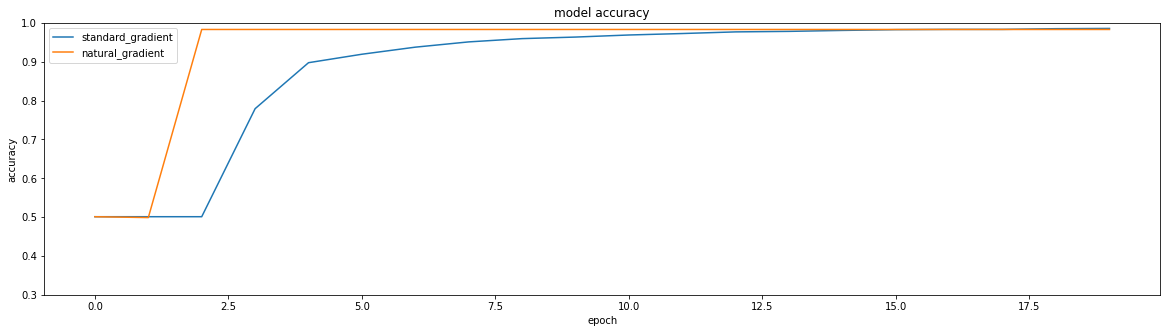

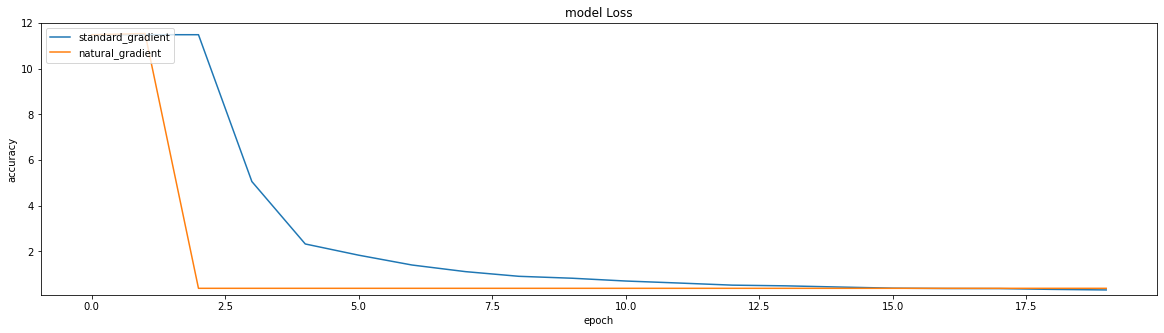

In [102]:
##Plotting with multiple initializations - With different learning rates
epochs = 20
accuracies_standard = [0]*epochs
losses_standard = [0]*epochs
accuracies_natural = [0]*epochs
losses_natural = [0]*epochs
iterations = 5
for i in range(iterations):
    print("Iteration number : " + str(i+1))
    weight_init = np.random.rand(X_tr.shape[1])
    ## 0.000003 Is the maximum rate where standard gradient was not sketchy (Prof. Tom Fletcher instructed to  choose the maX
    ## LR which is not sketchy)
    lr = 0.000003
    print("Training For standard gradient descent")
    obj1 = LogidticRegression(is_natural_gradient = False)
    model1= obj1.fit(X_tr,y_tr, weight_init, lr, epochs)
    accuracies_standard = list(map(add,obj1.train_accuracies,  accuracies_standard))
    losses_standard = list(map(add,obj1.losses,  losses_standard))
    lr_natural = 0.1
    print("Training For natural gradient descent")
    obj2 = LogidticRegression(is_natural_gradient = True)
    model2= obj2.fit(X_tr,y_tr, weight_init, lr_natural, epochs)
    accuracies_natural = list(map(add,obj2.train_accuracies,  accuracies_natural))
    losses_natural = list(map(add,obj2.losses,  losses_natural))
accuracies_standard  = [x / iterations for x in accuracies_standard]
losses_standard = [x / iterations for x in losses_standard]
accuracies_natural = [x / iterations for x in accuracies_natural]
losses_natural = [x / iterations for x in losses_natural]
model_plots(accuracies_standard, losses_standard, accuracies_natural, losses_natural)

Natural gradient converges faster because it mitigating the catastrophic effects of pathological curvature in the objective function

----------